In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.climate_invariant import *

In [21]:
from sklearn.metrics import confusion_matrix

## Analyzing bin class distributions for each level

In [2]:
def _one_hot_to_class_num(Y):
    #inp of shape Nx64Xbin_size
    return np.argmax(Y,axis=-1)

In [3]:
file_name = '/scratch/ankitesh/data/new_data_for_v2_100.nc'

In [4]:
ds = xr.open_dataset(file_name)

In [5]:
sub_sample = ds['Y'][:10000]

In [6]:
classes = _one_hot_to_class_num(sub_sample.values)

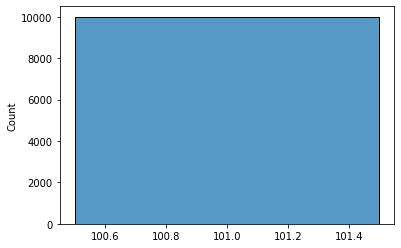

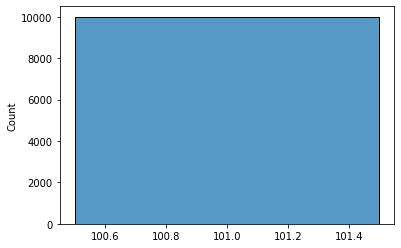

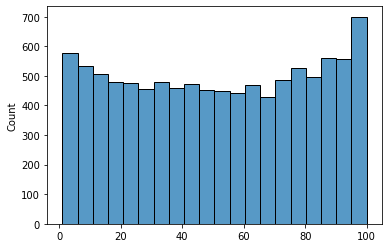

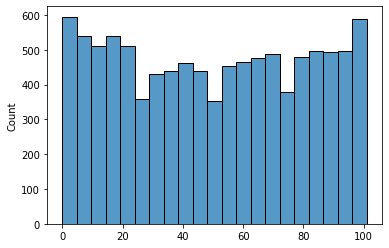

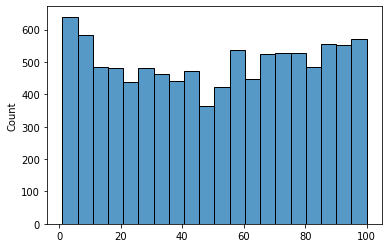

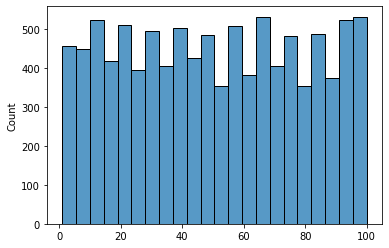

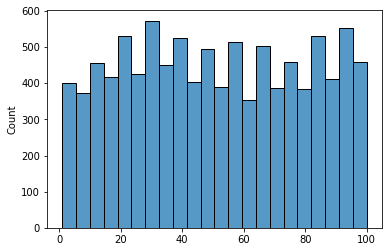

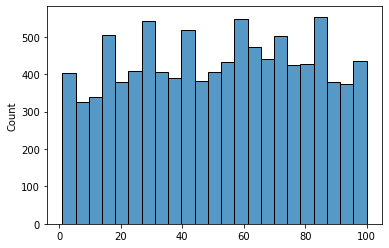

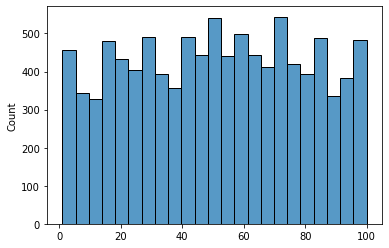

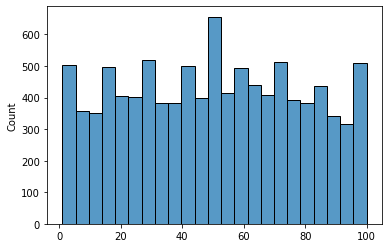

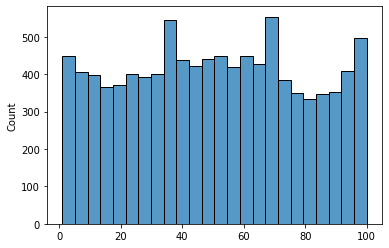

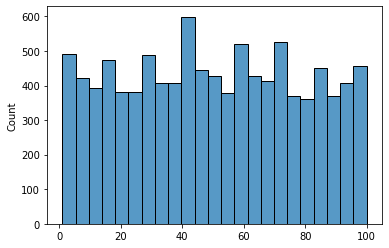

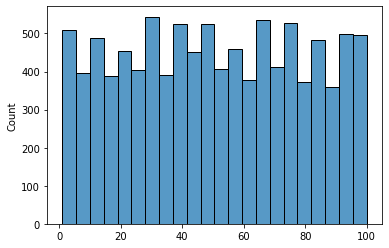

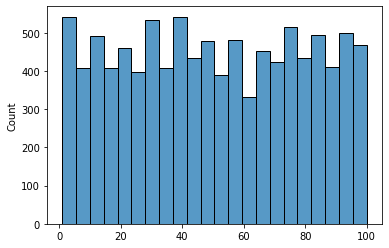

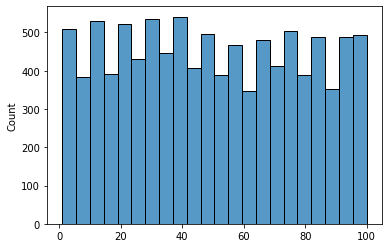

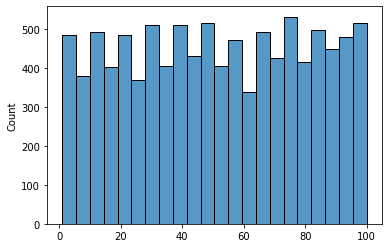

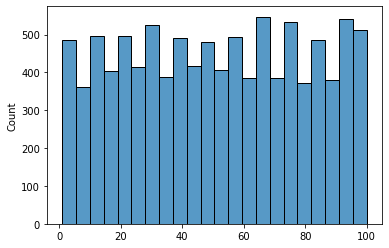

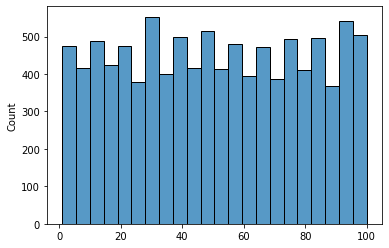

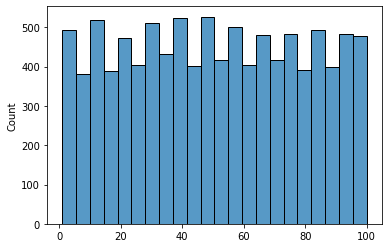

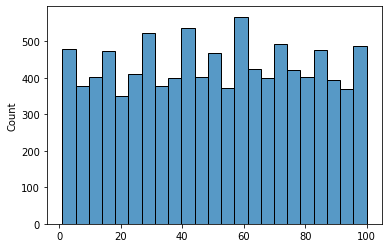

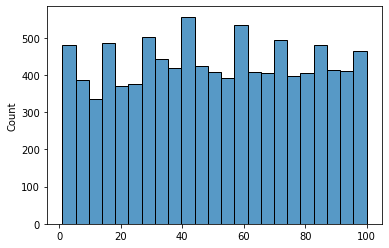

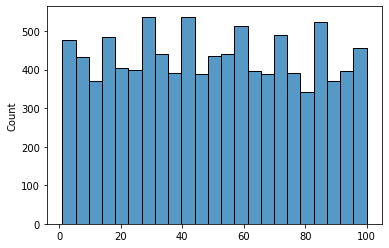

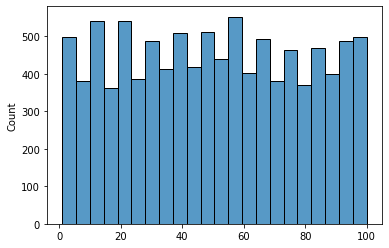

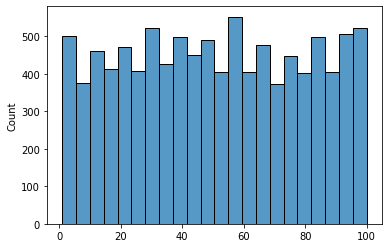

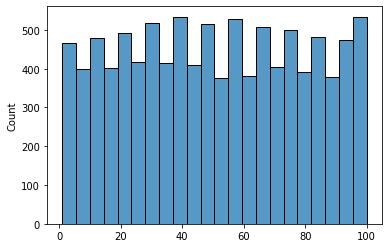

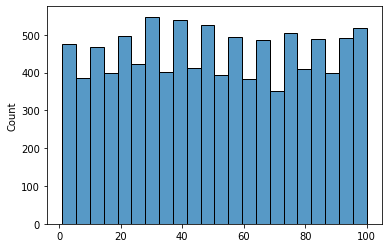

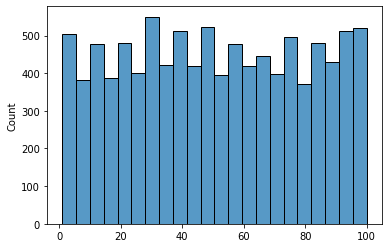

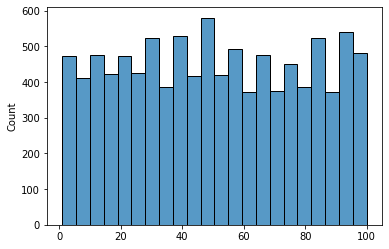

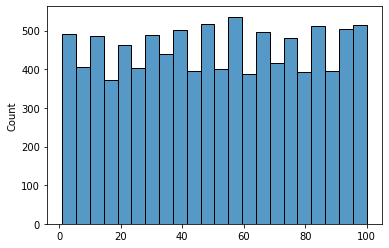

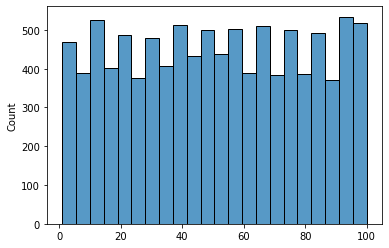

In [8]:
for i in range(30):
    sns.histplot(classes[:,i])
    plt.show()

## Relation between input and class distribution

In [27]:
# Carry out PCA for the input and then proceed

In [ ]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

## Confusion Matrix 

In [4]:
# load the trained model
model_file = '/scratch/ankitesh/models/BF_Classification_bin_size_100_model_v2.hdf5'
model = load_model(model_file)

In [5]:
class DataGeneratorClassification(tf.keras.utils.Sequence):
    def __init__(self, data_fn, input_vars, output_vars, percentile_path, data_name,
                 norm_fn=None, input_transform=None, output_transform=None,
                 batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True, bin_size=100):
        # Just copy over the attributes
        self.data_fn, self.norm_fn = data_fn, norm_fn
        self.input_vars, self.output_vars = input_vars, output_vars
        self.batch_size, self.shuffle = batch_size, shuffle
        self.bin_size = bin_size
        self.percentile_bins = load_pickle(percentile_path)['Percentile'][data_name]
        self.enc = OneHotEncoder(sparse=False)
        classes = np.arange(self.bin_size+2)
        self.enc.fit(classes.reshape(-1,1))
        # Open datasets
        self.data_ds = xr.open_mfdataset(data_fn)
        if norm_fn is not None: self.norm_ds = xr.open_dataset(norm_fn)
     # Compute number of samples and batches
        self.n_samples = self.data_ds.X.shape[0]
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)

        self.n_inputs, self.n_outputs = 64, 64
        
                # Initialize input and output normalizers/transformers
        if input_transform is None:
            self.input_transform = Normalizer()
        elif type(input_transform) is tuple:
            ## normalize flag added by Ankitesh
            self.input_transform = InputNormalizer(
                self.norm_ds,normalize_flag, input_vars, input_transform[0], input_transform[1], var_cut_off)
        else:
            self.input_transform = input_transform  # Assume an initialized normalizer is passed
            
            
        if output_transform is None:
            self.output_transform = Normalizer()
        elif type(output_transform) is dict:
            self.output_transform = DictNormalizer(self.norm_ds, output_vars, output_transform)
        else:
            self.output_transform = output_transform  # Assume an initialized normalizer is passed

        # Now close the xarray file and load it as an h5 file instead
        # This significantly speeds up the reading of the data...
        if not xarray:
            self.data_ds.close()
            self.data_ds = h5py.File(data_fn, 'r')
    
    def __len__(self):
        return self.n_batches
     
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch_X = self.data_ds['X'][start_idx:end_idx]
        Y = self.data_ds['Y'][start_idx:end_idx]
        # Normalize
        X = self.input_transform.transform(batch_X)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(self.n_batches)
        if self.shuffle: np.random.shuffle(self.indices)

In [6]:
scale_dict = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
TRAIN_FILE_ONEHOT = '/scratch/ankitesh/data/new_data_for_v2_100.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
data_path = '/fast/ankitesh/data/'

In [7]:
train_gen = DataGeneratorClassification(
    data_fn=f'{TRAIN_FILE_ONEHOT}', 
    input_vars=['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'], 
    output_vars=['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS'], 
    percentile_path='/export/nfs0home/ankitesg/data/percentile_data.pkl', 
    data_name = 'M4K',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    norm_fn = f'{data_path}{NORMFILE}',
    batch_size=1024,
    bin_size=100
)

In [14]:
y_true = train_gen[0][1]

In [11]:
with tf.device("/gpu:2"):
    y_pred = model.predict_on_batch(train_gen[0][0])

In [13]:
y_pred[0]

<tf.Tensor: id=1371, shape=(64, 102), dtype=float32, numpy=
array([[9.7199679e-13, 7.3857527e-13, 1.0350130e-12, ..., 7.2107137e-13,
        7.7801508e-13, 1.0000000e+00],
       [5.5205103e-13, 6.2825098e-13, 7.2063411e-13, ..., 7.3432471e-13,
        4.5319109e-13, 1.0000000e+00],
       [9.7313901e-08, 5.8582641e-06, 1.1024867e-03, ..., 3.6661366e-03,
        1.3432080e-05, 4.4728993e-10],
       ...,
       [1.8407476e-18, 2.1733286e-18, 2.5683009e-18, ..., 0.0000000e+00,
        0.0000000e+00, 2.0003090e-18],
       [3.1486969e-10, 2.0618529e-21, 1.7561076e-17, ..., 1.5145647e-24,
        1.1957824e-30, 3.5701600e-10],
       [8.3984528e-11, 1.6179489e-25, 1.1635428e-19, ..., 3.1831570e-02,
        5.6637367e-03, 6.0795299e-11]], dtype=float32)>

In [15]:
y_true[0]

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
_one_hot_to_class_num(y_true)

array([[101, 101,  80, ...,  60,  53,  75],
       [101, 101,  76, ...,  55,   8,  12],
       [101, 101,  50, ...,  52,  52,  76],
       ...,
       [101, 101,  75, ...,  49, 100,  85],
       [101, 101,  10, ...,  49,  87,  90],
       [101, 101,  59, ...,  49,  78,  33]])

In [19]:
_one_hot_to_class_num(y_pred)

array([[101, 101,  95, ...,  59,  68,  96],
       [101, 101,  90, ...,  55,   9,   8],
       [101, 101,  91, ...,  51,  36,  24],
       ...,
       [101, 101,  92, ...,  49, 100,  90],
       [101, 101,  92, ...,  49,  90,  89],
       [101, 101,  92, ...,  49,  79,  67]])

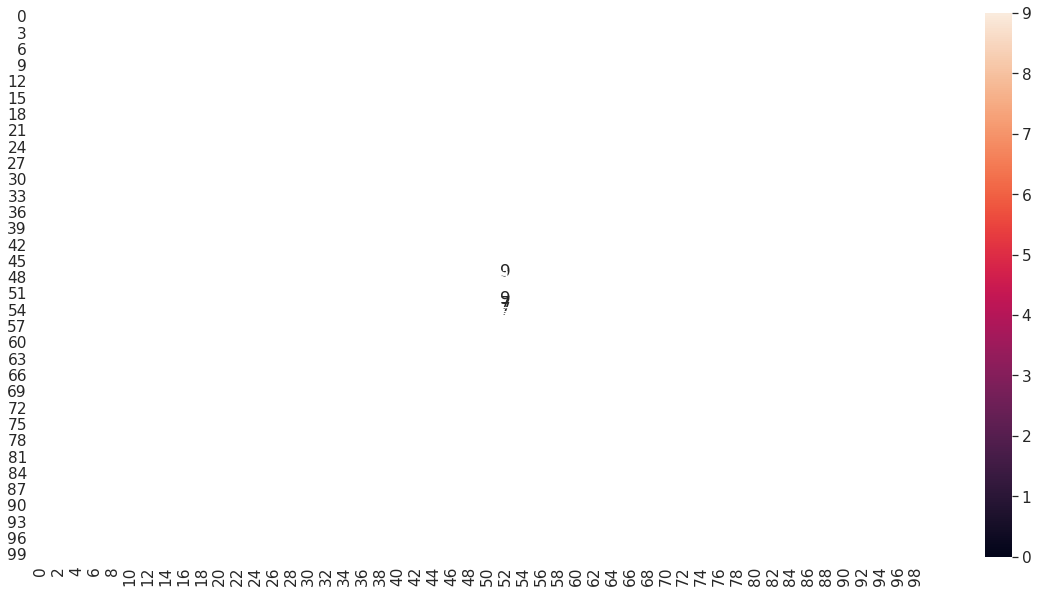

In [39]:
ilev = 10
plt.figure(figsize=(20,10))
y_true_index = _one_hot_to_class_num(y_true[:,ilev])
y_pred_index = _one_hot_to_class_num(y_pred[:,ilev])
matrix = confusion_matrix(y_true_index,y_pred_index)
sns.set(font_scale=1.4) # for label size
sns.heatmap(matrix,annot=True, fmt="d",linewidths=20)

In [44]:
y_true_index.shape

(1024,)

In [42]:
matrix.shape

(100, 100)

In [46]:
mat = np.zeros((102,102))
for i in range(y_true_index.shape[0]):
    mat[y_true_index[i]][y_pred_index[i]] += 1

In [47]:
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 6., 1., ..., 0., 1., 0.],
       [0., 4., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 3., 0.],
       [0., 2., 2., ..., 0., 6., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

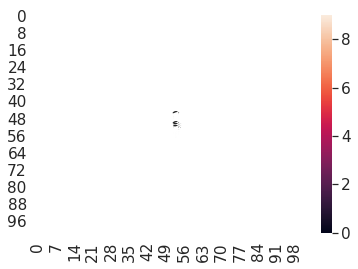

In [50]:
sns.heatmap(mat,annot=True,linewidths=20)

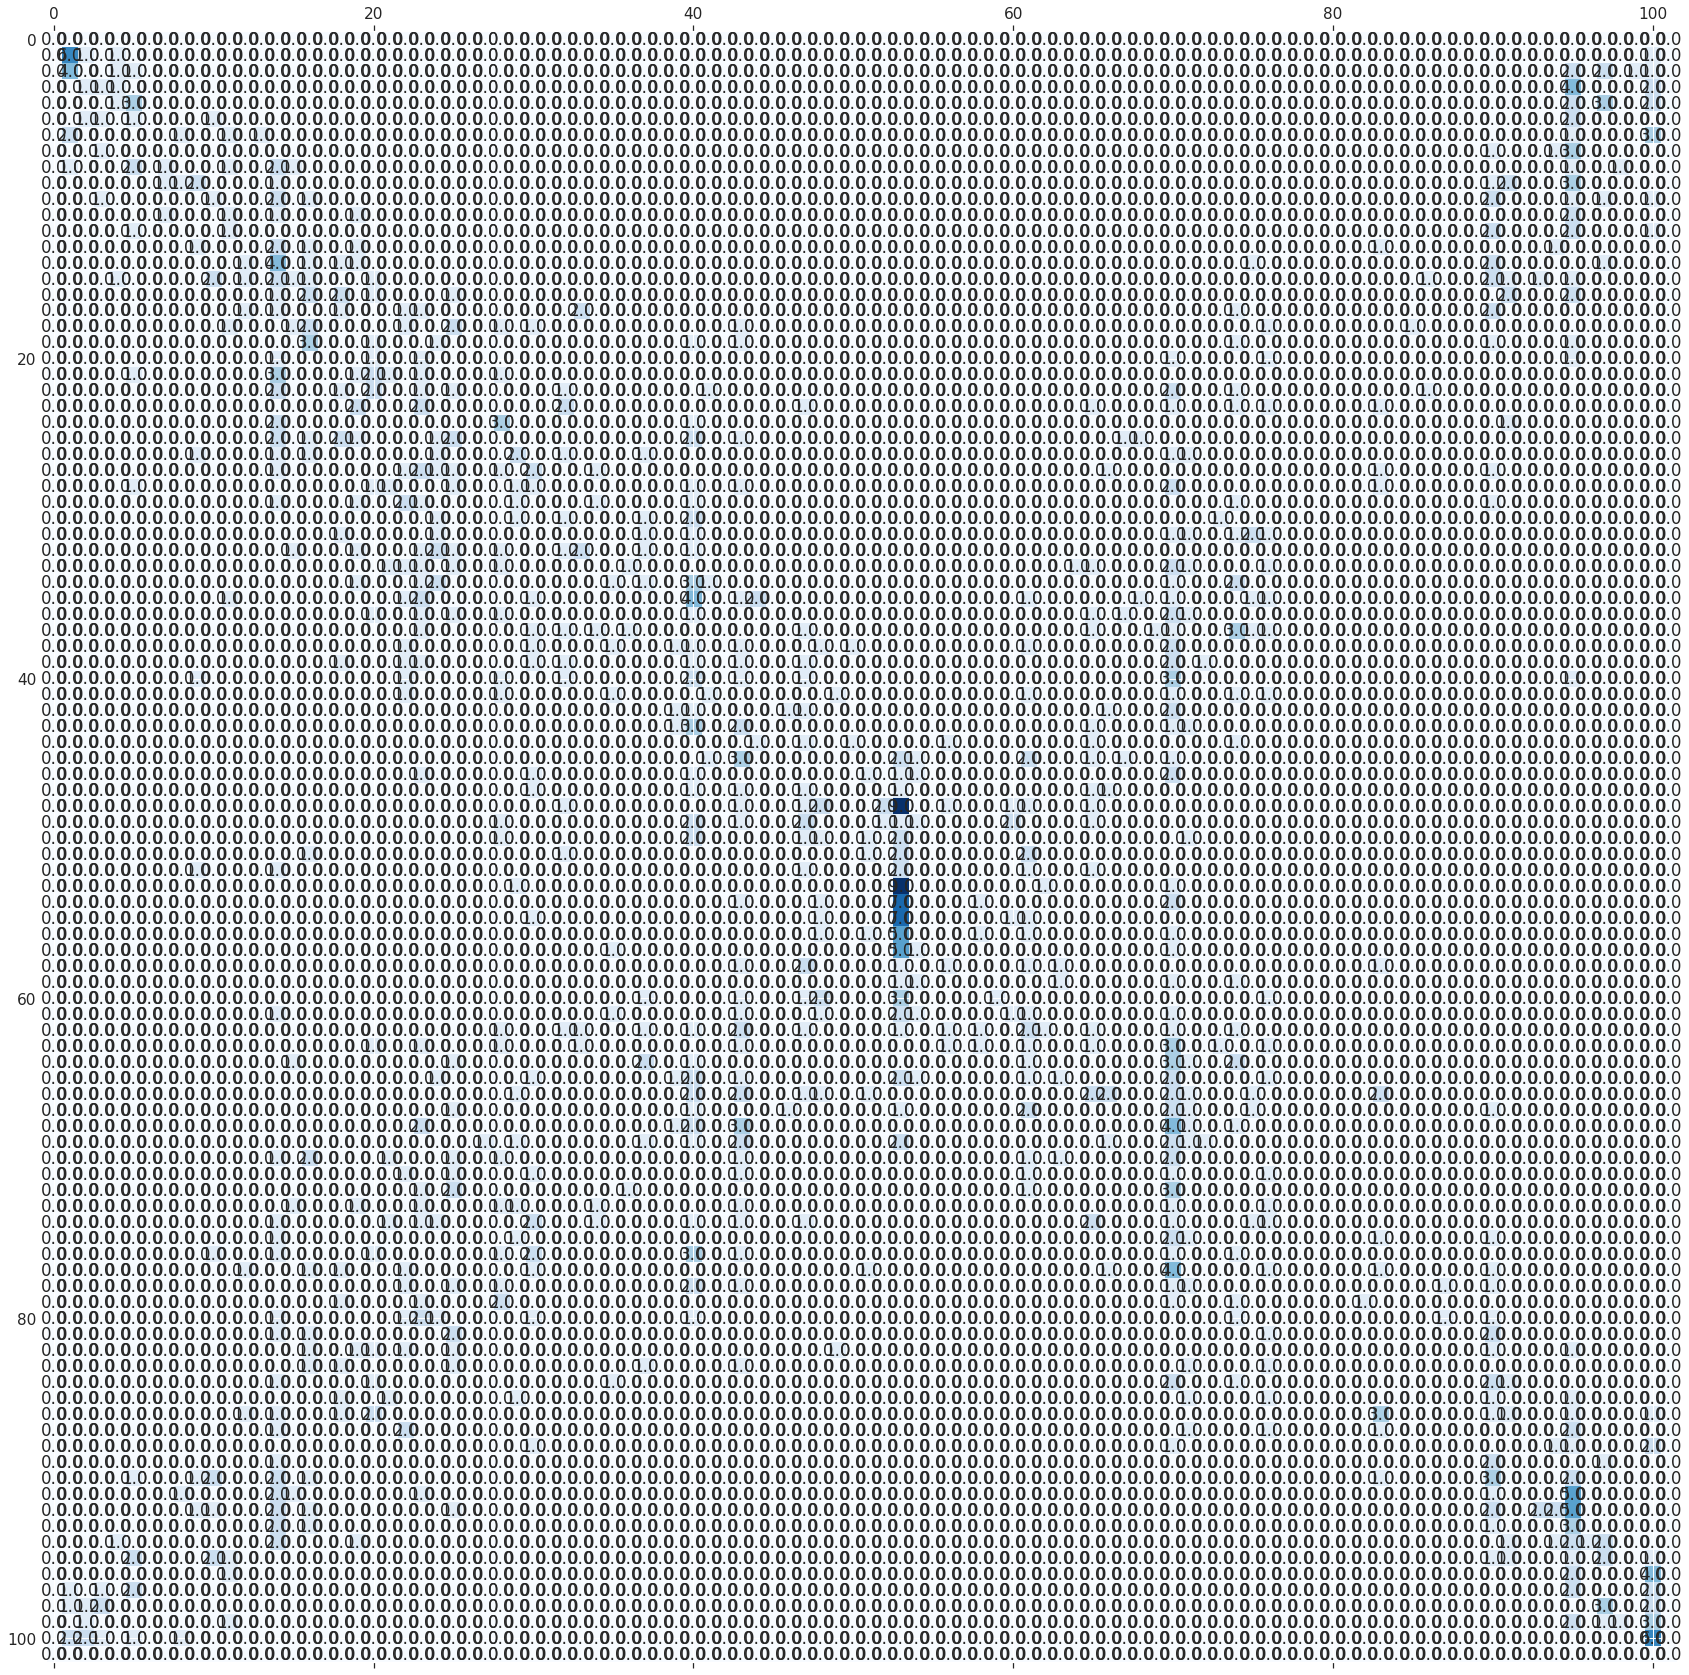

In [60]:

fig, ax = plt.subplots(figsize=(30,30))
min_val, max_val = 0, 101
ax.matshow(mat, cmap=plt.cm.Blues)
for i in range(102):
    for j in range(102):
        c = mat[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
